In [1]:
#import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np

#env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
plt.rcParams['figure.dpi'] = 100

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, layer_depth, layers = 1):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, layer_depth)
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(nn.Linear(layer_depth, layer_depth))
        #self.layer2 = nn.Linear(layer_depth, layer_depth)
        self.layer3 = nn.Linear(layer_depth, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        for i in range(len(self.layers)):
            x = F.relu(self.layers[i](x))
        #x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
# Daten laden
df = pd.read_csv('stockmarket_data.csv', decimal='.')
df_dis = df[(df['stock'] == 'DIS')]
df_msft = df[(df['stock'] == 'MSFT')]
df_vow3 = df[(df['stock'] == 'VOW3')]
df_jnj = df[(df['stock'] == 'JNJ')]
df_r6C0 = df[(df['stock'] == 'R6C0')]
df_date = df['Date'].unique()

data = df.to_numpy().T

companies = ['MSFT', 'VOW3', 'JNJ', 'DIS', 'R6C0']
stockmarket_data = np.array([[[0],[0],[0],[0],[0],[0]]])
bond_value = 1

for i in range(len(df_date)):
    date = df_date[i]
    #print('date', date)
    row_dis = df_dis[(df_dis['Date'] == date)]
    row_msft = df_msft[(df_msft['Date'] == date)]
    row_vow3 = df_vow3[(df_vow3['Date'] == date)]
    row_jnj = df_jnj[(df_jnj['Date'] == date)]
    row_r6C0 = df_r6C0[(df_r6C0['Date'] == date)]

    if len(row_dis) * len(row_msft) * len(row_vow3) * len(row_jnj) * len(row_r6C0) != 0:
        bond_value *= 1.00005
        #print(np.array([[row_dis['Close'], row_msft['Close'], row_vow3['Close'], row_jnj['Close'], row_r6C0['Close']]]))
        stockmarket_data = np.concatenate((stockmarket_data,
                                            np.array([[[bond_value], row_dis['Close'], row_msft['Close'], row_vow3['Close'], row_jnj['Close'], row_r6C0['Close']]])), axis=0)
    '''else:
        print('date', date)
        print('DIS', row_dis)
        print('MSFT ', row_msft)
        print('VOW3 ',row_vow3)
        print('JNJ ',row_jnj)
        print('R6C0 ',row_r6C0)'''
stockmarket_data = stockmarket_data.reshape((len(stockmarket_data),6))
stockmarket_data = np.delete(stockmarket_data, 0, 0)

In [5]:
# Spielumgebung definieren
class stockmarket():

    #Initialisierung des Spiels
    def __init__(self, stockmarketdata, start_budget, last_day):
        self.stockmarketdata = stockmarketdata
        self.start_budget = start_budget
        self.budget = start_budget
        self.day = 0
        self.num_days = len(stockmarketdata)
        #self.actionspace = np.array(range(2**len(stockmarketdata[0])))
        #self.actionspace_length = 2**len(stockmarketdata[0])
        self.actionspace = np.array(range(len(stockmarketdata[0])))
        self.actionspace_length = len(stockmarketdata[0])
        self.last_day = last_day
        

    def step(self, action):
        terminated = False
        reward = 0
        roi = 0

        '''#action aus 0-64 in array aus 6 Nullen und Einsen umwandeln -> 0 = nicht gekauft, 1 = gekauft
        portfolio_action = []

        for i in range(self.actionspace_length):
            portfolio_action.append(action % 2)
            action = math.floor(action / 2)'''

        self.day += 1

        if self.day == self.num_days or self.budget == 0 or self.day >= self.last_day:
            #run is over
            terminated = True

            return np.array(self.state), 0, terminated
        else:
            #Profit berechnen

            '''for i in range(len(self.stockmarketdata[0])):
                reward += portfolio_action[i] * (self.budget * (self.stockmarketdata[self.day][i] / self.stockmarketdata[self.day - 1][i]) - self.budget)

            if sum(portfolio_action) > 0:
                reward /= sum(portfolio_action)'''
            
            reward = (self.budget * (self.stockmarketdata[self.day][action] / self.stockmarketdata[self.day - 1][action]) - self.budget)
            roi += (self.stockmarketdata[self.day][action] / self.stockmarketdata[self.day - 1][action])

        reward = np.float32(reward)

        #reward -= self.budget

        self.budget += reward

        #print('reward ', reward)
        #print('budget ', self.budget)

        #self.state = np.concatenate(([self.budget],self.stockmarketdata[self.day]), axis=0)
        self.state = self.stockmarketdata[self.day]
        
        return np.array(self.state, dtype=np.float32), reward, terminated

    def reset(self):
        #state = [budget, stockmarketdata]
        #self.state = np.concatenate(([self.budget],self.stockmarketdata[0]), axis=0)
        self.state = self.stockmarketdata[0]
        self.day = 0
        self.budget = self.start_budget

        return np.array(self.state, dtype=np.float32), {}

In [39]:
env = stockmarket(stockmarket_data, 100, 10)

In [40]:
#calculate optimal and "lazy" reward
optimal_reward = env.start_budget
lazy_reward = env.start_budget

upper_bound = min(len(env.stockmarketdata), env.last_day)

for t in range(upper_bound):
    if t == 0:
        t = 1

    max_reward = 0

    for i in range(len(env.stockmarketdata[0])):
        #lazy reward picks bond + all stocks equally
        lazy_reward += (1 / env.actionspace_length) * (lazy_reward * (env.stockmarketdata[t][i] / env.stockmarketdata[t - 1][i]) - lazy_reward)

        #optimal reward stock/bond with biggest reward
        reward = 1 * (optimal_reward * (env.stockmarketdata[t][i] / env.stockmarketdata[t - 1][i]) - optimal_reward)

        if reward > max_reward:
            max_reward = reward

    optimal_reward += max_reward

print('optimal reward: ', optimal_reward)
print('lazy reward: ', lazy_reward)

optimal reward:  378.2405787009821
lazy reward:  104.71369130729852


In [41]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.099
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.actionspace_length
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

layer_depth = 1000
layers = 1

policy_net = DQN(n_observations, n_actions, layer_depth, layers).to(device)
target_net = DQN(n_observations, n_actions, layer_depth, layers).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

In [42]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[np.random.choice(env.actionspace)]], device=device, dtype=torch.long)


episode_durations = []
episode_returns = []
episode_returns_averaged = []
lazy_bound = []
optimal_bound = []
EXPONENTIAL_AVG_FACTOR = 0.02


def plot_metrics(show_result=False):
    plt.figure(1)
    returns_t = torch.tensor(episode_returns, dtype=torch.float)
    returns_avg_t = torch.tensor(episode_returns_averaged, dtype=torch.float)
    lazy_bound_t = torch.tensor(lazy_bound, dtype=torch.float)
    optimal_bound_t = torch.tensor(optimal_bound, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Returns')
    plt.plot(returns_t.numpy(), '+')
    plt.plot(returns_avg_t.numpy())
    plt.plot(lazy_bound_t.numpy(), 'r--')
    plt.plot(optimal_bound_t.numpy(), 'g--')
    plt.yscale('log')

    '''
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())'''

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [43]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    #print('model got optimized')

In [44]:
print(policy_net)

DQN(
  (layer1): Linear(in_features=6, out_features=5, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=5, bias=True)
  )
  (layer3): Linear(in_features=5, out_features=6, bias=True)
)


In [45]:
EPS_START = 0.9
EPS_END = 0.0005
EPS_DECAY = 5000
EXPONENTIAL_AVG_FACTOR = 0.02
print(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY))

0.9


Complete
current greed rate:  0.12223408727133314
current avg reward:  106.21789987417932


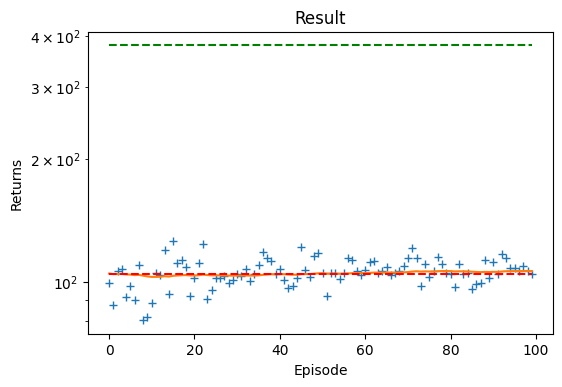

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [47]:
if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 100

num_episodes = 100

for i_episode in range(num_episodes):
    #print('Episode ', i_episode)
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        #print('t ', t)
        action = select_action(state)
        observation, reward, terminated = env.step(action.item())
        reward = torch.tensor([np.float32(reward)], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        #print(state, action, next_state, reward)
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            if len(episode_returns_averaged) == 0:
                episode_returns_averaged.append(lazy_reward)
            else:
                episode_returns_averaged.append(episode_returns_averaged[-1] * (1 - EXPONENTIAL_AVG_FACTOR) + env.budget * (EXPONENTIAL_AVG_FACTOR))
            episode_returns.append(env.budget)
            lazy_bound.append(lazy_reward)
            optimal_bound.append(optimal_reward)
            plot_metrics()
            break

print('Complete')
print('current greed rate: ', EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY))
print('current avg reward: ', episode_returns_averaged[-1] )
plot_metrics(show_result=True)
plt.ioff()
plt.show()